# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 07.12.2018

Мягкий дедлайн: 05:59MSK 18.12.2018

Жесткий дедлайн: 05:59MSK 19.12.2018

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

__Задание 1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc

In [16]:
data = pd.read_csv('application_train.csv')
y = data.TARGET.values
data = data.drop(columns=['TARGET', 'SK_ID_CURR'])
data = data.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=0)

__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [3]:
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
import time

In [17]:
X_train_ = X_train.select_dtypes(include=['int64', 'float64'])
X_test_ = X_test.select_dtypes(include=['int64', 'float64'])

In [5]:
catboost_clf = CatBoostClassifier(logging_level='Silent')
t = time.clock()
catboost_clf.fit(X_train_, y_train)
t = time.clock() - t
print('Catboost')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, catboost_clf.predict_proba(X_test_)[:, 1])
pr_auc = auc(recall, precision)
print('pr_auc = ', pr_auc)
print()

lgbm_clf = LGBMClassifier()
t = time.clock()
lgbm_clf.fit(X_train_, y_train)
t = time.clock() - t
print('LGBM')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, lgbm_clf.predict_proba(X_test_)[:, 1])
pr_auc = auc(recall, precision)
print('roc_auc = ', pr_auc)

Catboost
Fitting time = 206.08722100020663 seconds
pr_auc =  0.23451685341052356

LGBM
Fitting time = 11.82105048989149 seconds
roc_auc =  0.23147216787023922


Ответ: LightGBM отличается быстротой построения композиции (за счёт перебора значений гистограммы признака при построении вершины дерева, использования стратегии best-first), что видно из результатов. Catboost менее чувствителен к набору гиперпараметров, поэтому показывает лучший результат.

__Задание 3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [5]:
from sklearn.model_selection import GridSearchCV

params_catboost = {
    'depth': [4, 8, 16],
    'num_trees': [200, 400, 800],
    'learning_rate': [0.01, 0.1, 0.5],
    'loss_function': ['Logloss', 'CrossEntropy']
}

params_lgbm = {
    'max_depth': [4, 8, 16],
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.01, 0.1, 0.5],
    'objective': ['binary', 'cross_entropy']
}

catboost_grid = GridSearchCV(CatBoostClassifier(logging_level='Silent'), params_catboost, cv=3,
                             scoring='average_precision')
t = time.clock()
catboost_grid.fit(X_train_, y_train)
t = time.clock() - t
print('Catboost: fitting Gridsearch time = {} seconds'.format(t))

lgbm_grid = GridSearchCV(LGBMClassifier(), params_lgbm, cv=3, scoring='average_precision')
t = time.clock()
lgbm_grid.fit(X_train_, y_train)
t = time.clock() - t
print('LGBM: fitting Gridsearch time = {} seconds'.format(t))

KeyboardInterrupt: 

In [ ]:
print('Best params for catboost: ', catboost_grid.best_params_)
print('Best params for lgbm: ', lgbm_grid.best_params_)

Изначально я ставила GridSearch без параметра scoring='average_precision', потом решила, что так будет правильней, тк в начале ноутбука указано, что нужно оценивать модели с помощью площади под precision-recall кривой. Я перезапустила все блоки, но результатов не дождалась.
Поэтому в каждом следующем задании я в комментарии напишу примерные результаты, которые получались до параметра 'average_precision'.

Catboost: fitting Gridsearch time = 22000 seconds
LGBM: fitting Gridsearch time = 8000 seconds

Best params for catboost: {'learning_rate': 0.1, 'depth': 16, 'loss_function': 'Logloss', 'num_trees': 400}
Best params for lgbm: {'max_depth': 3, 'objective': 'binary', 'learning_rate': 0.1, 'n_estimators': 800}

Из результатов можно сделать вывод, что catboost выбирает меньшее число моделей с большей глубиной дерева, а lgbm - больше деревьев с меньшей глубиной.

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

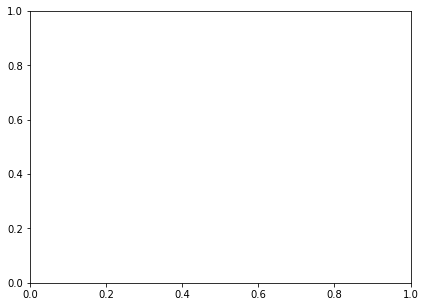

In [6]:
from scipy.interpolate import spline

def smooth_data(x, y):
    x_new = np.linspace(x.min(), x.max(), 100)
    y_new = spline(x, y, x_new)
    return x_new, y_new

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
indexes = (catboost_grid.cv_results_['param_loss_function'].data == 'Logloss') & (
    catboost_grid.cv_results_['param_learning_rate'].data == 0.1) & (
    catboost_grid.cv_results_['param_num_trees'].data == 200)
depth = catboost_grid.cv_results_['param_depth'].data[indexes]
scores = catboost_grid.cv_results_['mean_test_score'][indexes]
depth[-1] = 32
depth, scores = smooth_data(depth, scores)
plt.plot(depth, scores, label='catboost')

indexes = (lgbm_grid.cv_results_['param_objective'].data == 'binary') & (
    lgbm_grid.cv_results_['param_learning_rate'].data == 0.1) & (
    lgbm_grid.cv_results_['param_n_estimators'].data == 200)
depth = lgbm_grid.cv_results_['param_max_depth'].data[indexes]
depth[-1] = 32
scores = lgbm_grid.cv_results_['mean_test_score'][indexes]
depth, scores = smooth_data(depth, scores)
plt.plot(depth, scores, label='lgbm')

plt.title("Params: Loggloss, lr = 0.1, num_trees = 200")
plt.xlabel("max_depth")
plt.ylabel("mean_test_score")
plt.xticks([2., 4., 8., 40.], [2, 4, 8, -1])
plt.legend()

plt.subplot(1, 2, 2)
indexes = (catboost_grid.cv_results_['param_loss_function'].data == 'Logloss') & (
    catboost_grid.cv_results_['param_learning_rate'].data == 0.1) & (
    catboost_grid.cv_results_['param_depth'].data == 8)
num_trees = catboost_grid.cv_results_['param_num_trees'].data[indexes]
scores = catboost_grid.cv_results_['mean_test_score'][indexes]
num_trees, scores = smooth_data(num_trees, scores)
plt.plot(num_trees, scores, label='catboost')

indexes = (lgbm_grid.cv_results_['param_objective'].data == 'binary') & (
    lgbm_grid.cv_results_['param_learning_rate'].data == 0.1) & (
    lgbm_grid.cv_results_['param_max_depth'].data == 8)
num_trees = lgbm_grid.cv_results_['param_n_estimators'].data[indexes]
scores = lgbm_grid.cv_results_['mean_test_score'][indexes]
num_trees, scores = smooth_data(num_trees, scores)
plt.plot(num_trees, scores, label='lgbm')

plt.title("Params: Loggloss, lr = 0.1, depth = 8")
plt.xlabel("num_trees")
plt.ylabel("mean_test_score")
plt.legend()

В данном блоке у меня выведены результаты с предыдущего запуска, где в параметры depth входило значение -1 (None), при отрисовке графика я ставила это значение как 32.

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [18]:
data_obj = data.select_dtypes(include=['object'])
data_onehot = pd.get_dummies(data_obj.copy())
X_train_onehot, X_test_onehot, _, _ = train_test_split(data_onehot, y, test_size=0.3, random_state=0)
X_train_onehot = pd.concat([X_train_, X_train_onehot], axis=1)
X_test_onehot = pd.concat([X_train_, X_train_onehot], axis=1)

In [19]:
def make_count(column):
    C = 10
    d = (column.values.copy()).astype(str)
    mean = y.mean()
    vs, vs_counts = np.unique(d, return_counts=True)
    d_tiled = np.tile(d.reshape(-1, 1), (1, vs.size))
    y_tiled = np.tile(y.reshape(-1, 1), (1, vs.size))
    vs_tiled = np.tile(vs, (d_tiled.shape[0], 1))
    new_values = ((d_tiled == vs_tiled) & (y_tiled == 1)).sum(axis=0) + C * mean
    new_values = new_values / (vs_counts + C)
    new_values = np.tile(new_values, (d_tiled.shape[0], 1))
    new_values[d_tiled != vs_tiled] = 0
    new_values = new_values.sum(axis=1)
    return pd.Series(new_values, dtype=float)

data_count = data_obj.copy()
data_count = data_count.apply(make_count, axis='index')
data_count.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,0.083459,0.101417,0.085002,0.079616,0.081830,0.095884,0.089399,0.098073,0.077957,0.105783,0.081603,0.092994,0.069783,0.069435,0.074058,0.069650
1,0.083459,0.069994,0.085002,0.083249,0.074947,0.057560,0.053555,0.075599,0.077957,0.063046,0.077573,0.059172,0.069783,0.069435,0.070259,0.069650
2,0.054792,0.101417,0.072438,0.079616,0.081830,0.095884,0.089399,0.098073,0.077957,0.105783,0.077573,0.069791,0.086188,0.091511,0.091281,0.092607
3,0.083459,0.069994,0.085002,0.079616,0.081830,0.095884,0.089399,0.099440,0.077957,0.105783,0.081603,0.092994,0.086188,0.091511,0.091281,0.092607
4,0.083459,0.101417,0.085002,0.079616,0.081830,0.095884,0.089399,0.098073,0.077957,0.063046,0.081002,0.061129,0.086188,0.091511,0.091281,0.092607


In [20]:
data.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
X_train_count, X_test_count, _, _ = train_test_split(data_count, y, test_size=0.3, random_state=0)
X_train_count = pd.concat([X_train_, X_train_count], axis=1)
X_test_count = pd.concat([X_train_, X_train_count], axis=1)

In [22]:
X_train_count.shape

(215257, 120)

In [ ]:
params_catboost = {
    'depth': [None, 8],
    'num_trees': [200, 400, 800],
    'learning_rate': [0.01, 0.1]
}

catboost_grid_onehot = GridSearchCV(CatBoostClassifier(logging_level='Silent'), params_catboost,
                                    cv=3, scoring='average_precision')
t = time.clock()
catboost_grid_onehot.fit(X_train_onehot, y_train)
t = time.clock() - t
print('Catboost: One-hot-encoding: fitting Gridsearch time = {} seconds'.format(t))

catboost_grid_count = GridSearchCV(CatBoostClassifier(logging_level='Silent'), params_catboost,
                                   cv=3, scoring='average_precision')
t = time.clock()
catboost_grid_count.fit(X_train_count, y_train)
t = time.clock() - t
print('Catboost: count-encoding: fitting Gridsearch time = {} seconds'.format(t))

In [ ]:
params_lgbm = {
    'max_depth': [-1, 8],
    'n_estimators': [200, 400, 800],
    'learning_rate': [0.01, 0.1]
}

lgbm_grid_onehot = GridSearchCV(LGBMClassifier(), params_lgbm, cv=3, scoring='average_precision')
t = time.clock()
lgbm_grid_onehot.fit(X_train_onehot, y_train)
t = time.clock() - t
print('LGBM: One-hot-encoding: fitting Gridsearch time = {} seconds'.format(t))

lgbm_grid_count = GridSearchCV(LGBMClassifier(), params_lgbm, cv=3, scoring='average_precision')
t = time.clock()
lgbm_grid_count.fit(X_train_count, y_train)
t = time.clock() - t
print('LGBM: count-encoding: fitting Gridsearch time = {} seconds'.format(t))

In [ ]:
catboost_grid_self = GridSearchCV(CatBoostClassifier(logging_level='Silent'), params_catboost,
                                  cv=3, scoring='average_precision')
t = time.clock()
catboost_grid_self.fit(X_train, y_train)
t = time.clock() - t
print('Catboost: self-encoding: fitting Gridsearch time = {} seconds'.format(t))

In [ ]:
cat_names = list(data_obj.columns)

lgbm_grid_self = GridSearchCV(LGBMClassifier(), params_lgbm, cv=3, scoring='average_precision')
t = time.clock()
lgbm_grid_count.fit(X_train_count, y_train, categorical_feature=cat_names)
t = time.clock() - t
print('LGBM: self-encoding: fitting Gridsearch time = {} seconds'.format(t))

__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

In [38]:
catboost_clf = CatBoostClassifier(logging_level='Silent', learning_rate=0.1,
                                  depth=5, loss_function='Logloss', num_trees=400)
t = time.clock()
catboost_clf.fit(X_train_, y_train)
t = time.clock() - t
print('Catboost')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, catboost_clf.predict_proba(X_test_)[:, 1])
pr_auc = auc(recall, precision)
print('roc_auc = ', pr_auc)
print()

lgbm_clf = LGBMClassifier(max_depth=3, objective='binary', learning_rate=0.1, n_estimators=800)
t = time.clock()
lgbm_clf.fit(X_train_, y_train)
t = time.clock() - t
print('LGBM')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, lgbm_clf.predict_proba(X_test_)[:, 1])
pr_auc = auc(recall, precision)
print('roc_auc = ', pr_auc)

Catboost
Fitting time = 76.02663775676774 seconds
roc_auc =  0.23268389695753275

LGBM
Fitting time = 40.994238941137155 seconds
roc_auc =  0.23327935412115441


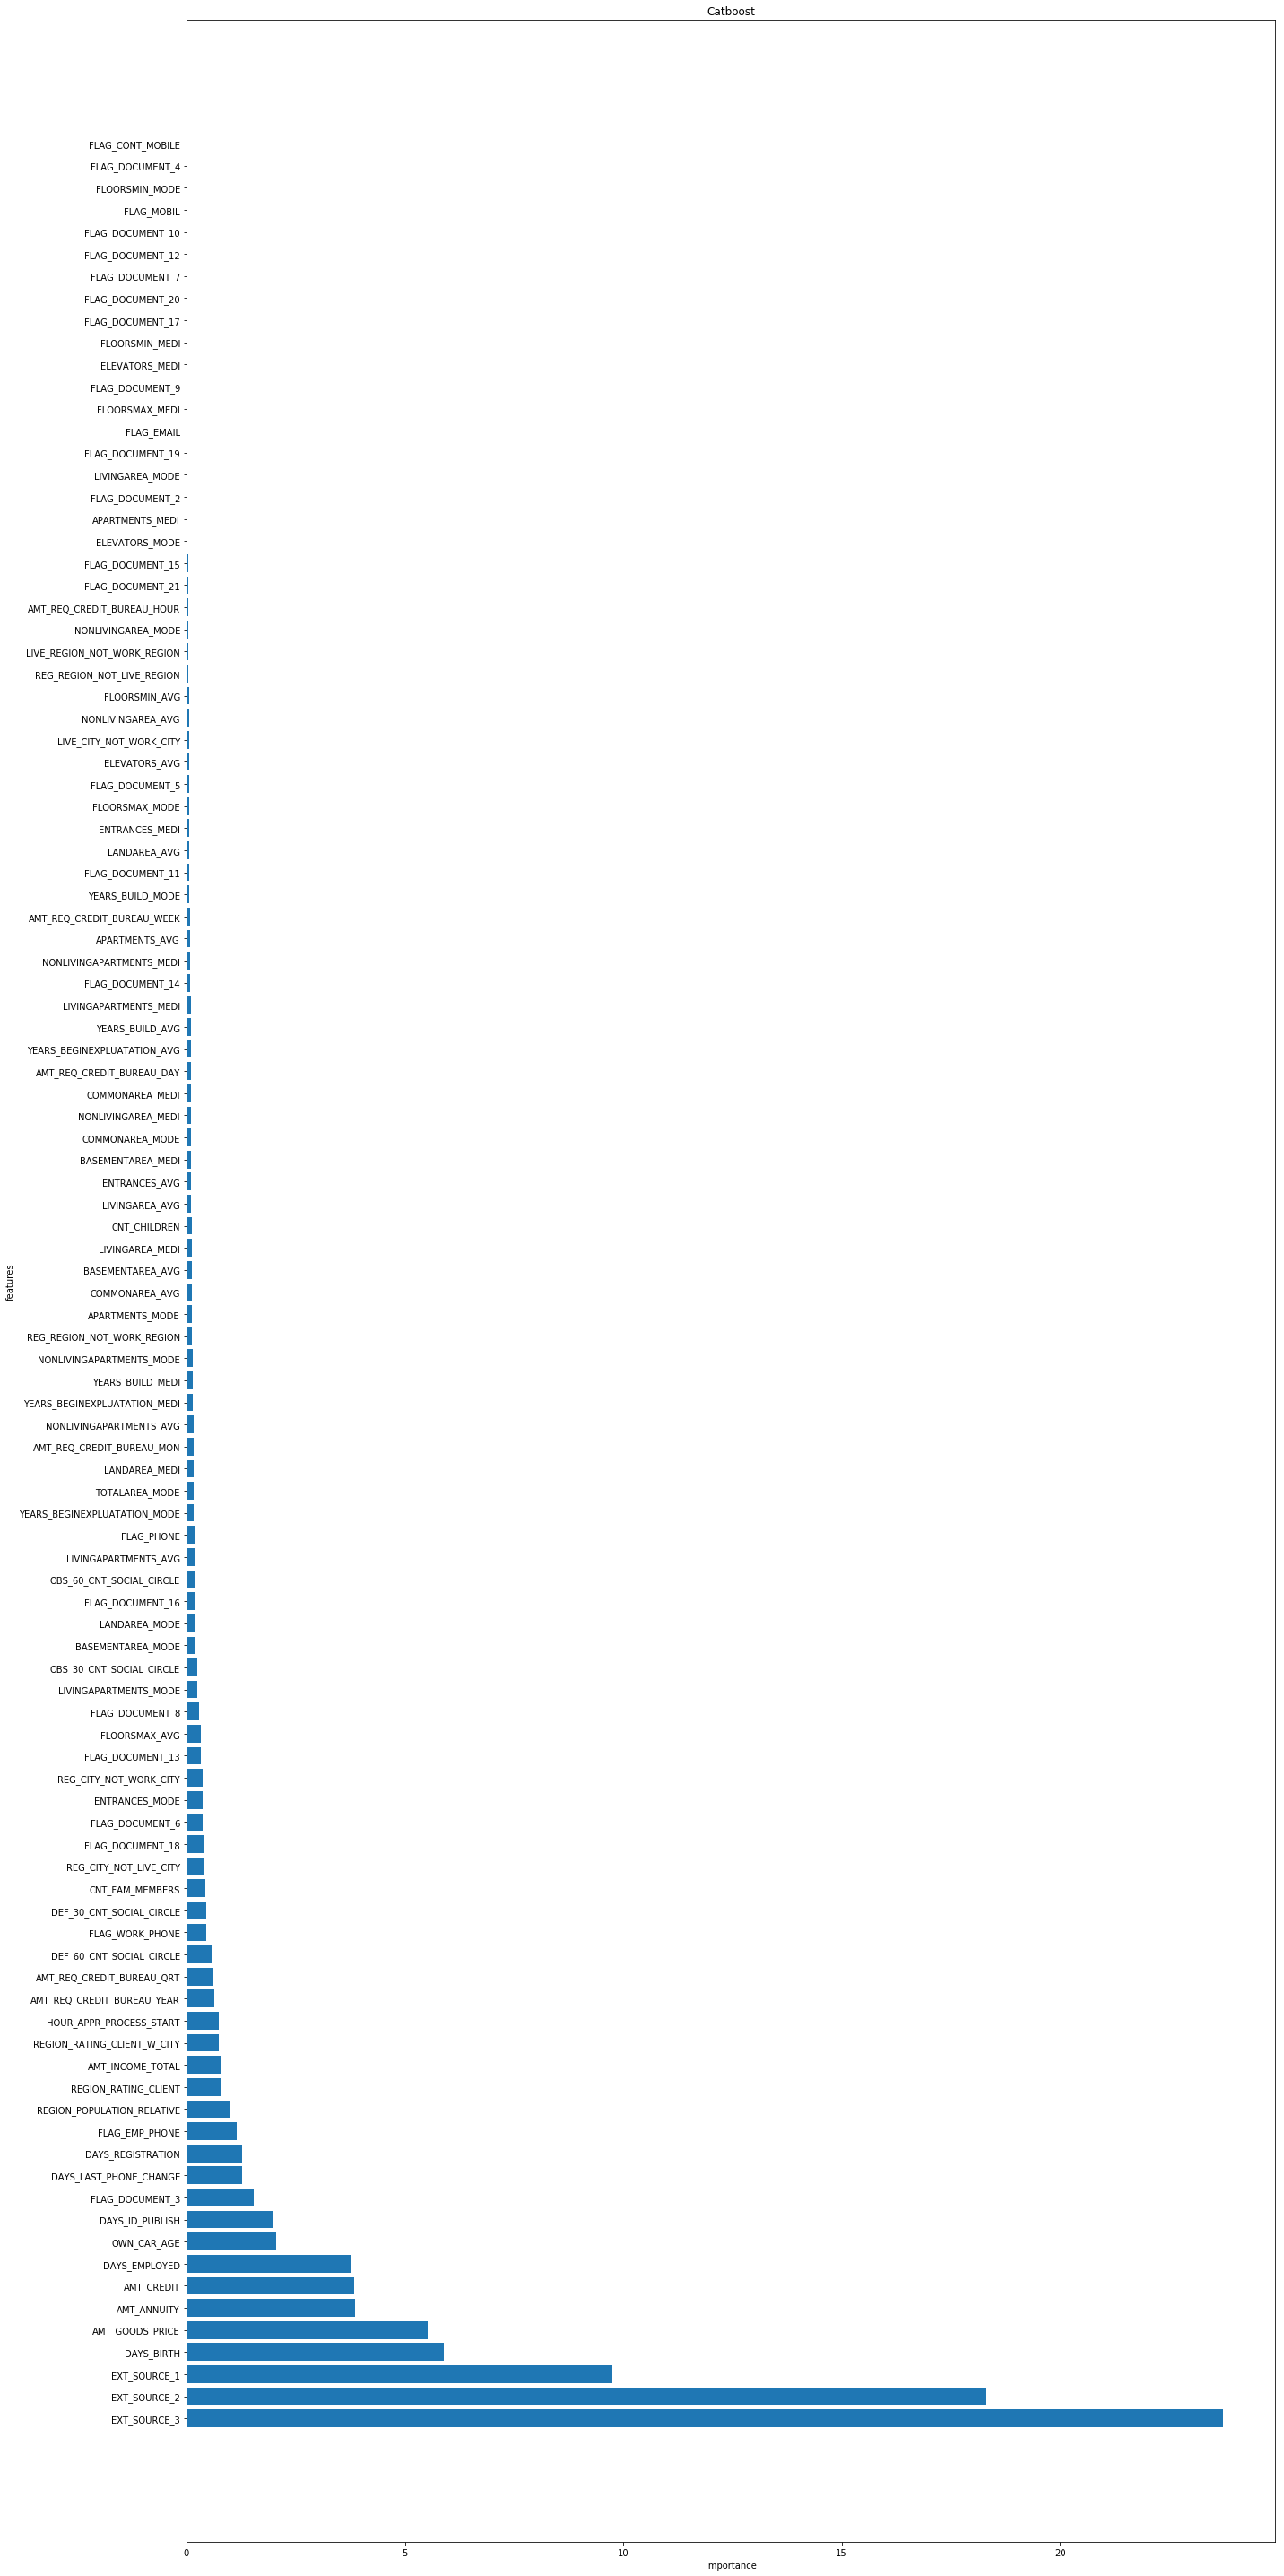

In [51]:
plt.figure(figsize=(20, 40))

importances = np.array(catboost_clf.feature_importances_)
features = np.array(X_train_.columns)
indexes = importances.argsort()
features = features[indexes][::-1]
importances.sort()
importances = importances[::-1]
plt.barh(np.arange(importances.size), importances, tick_label=features)
plt.title("Catboost")
plt.xlabel("importance")
plt.ylabel("features")

plt.tight_layout()

In [56]:
features_to_drop = features[importances < 1]
X_train_new = X_train_.drop(features_to_drop, axis=1)
X_test_new = X_test_.drop(features_to_drop, axis=1)

catboost_clf = CatBoostClassifier(logging_level='Silent', learning_rate=0.1,
                                  depth=5, loss_function='Logloss', num_trees=400)
t = time.clock()
catboost_clf.fit(X_train_new, y_train)
t = time.clock() - t
print('Catboost without unimportant features')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, catboost_clf.predict_proba(X_test_new)[:, 1])
pr_auc = auc(recall, precision)
print('roc_auc = ', pr_auc)
print()

Catboost without unimportant features
Fitting time = 41.93438218126539 seconds
roc_auc =  0.2280017069755442



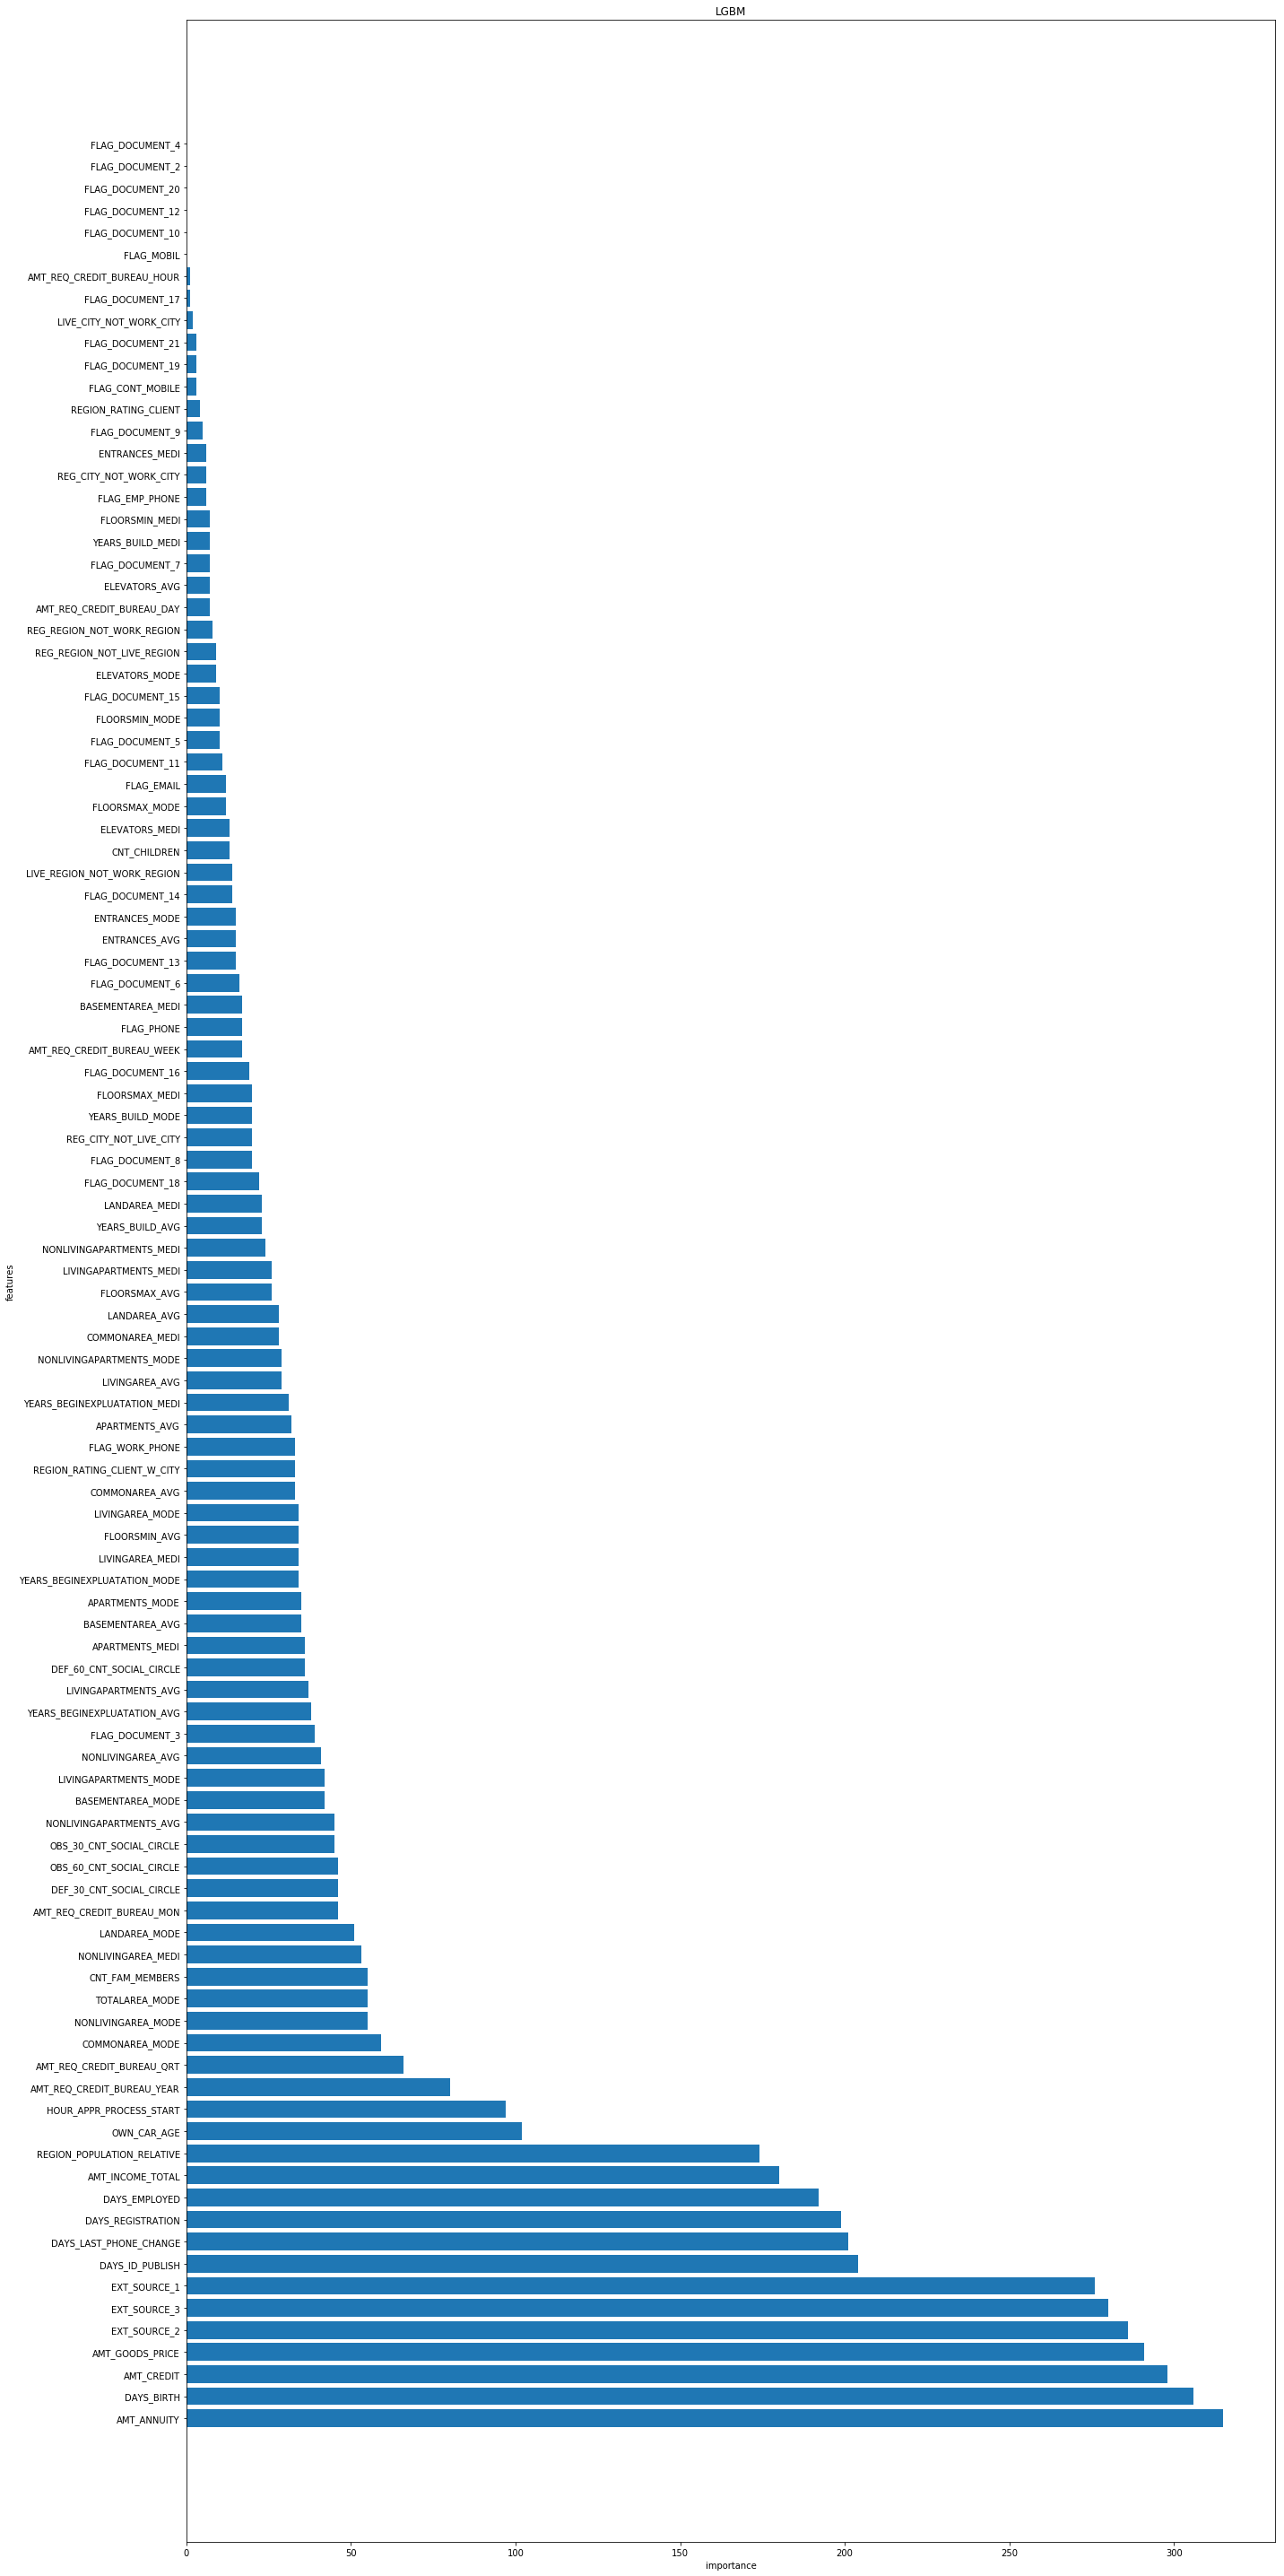

In [63]:
plt.figure(figsize=(20, 40))

importances = np.array(lgbm_clf.feature_importances_)
features = np.array(X_train_.columns)
indexes = importances.argsort()
features = features[indexes][::-1]
importances.sort()
importances = importances[::-1]
plt.barh(np.arange(importances.size), importances, tick_label=features)
plt.title("LGBM")
plt.xlabel("importance")
plt.ylabel("features")

plt.tight_layout()

In [64]:
features_to_drop = features[importances < 10]
X_train_new = X_train_.drop(features_to_drop, axis=1)
X_test_new = X_test_.drop(features_to_drop, axis=1)

lgbm_clf = LGBMClassifier(max_depth=3, objective='binary', learning_rate=0.1, n_estimators=800)
t = time.clock()
lgbm_clf.fit(X_train_new, y_train)
t = time.clock() - t
print('LGBM without unimportant features')
print('Fitting time = {} seconds'.format(t))
precision, recall, _ = precision_recall_curve(y_test, lgbm_clf.predict_proba(X_test_new)[:, 1])
pr_auc = auc(recall, precision)
print('roc_auc = ', pr_auc)
print()

LGBM without unimportant features
Fitting time = 32.9180588285235 seconds
roc_auc =  0.2343105451386597



In [ ]:
Время на обучение моделей уходит меньше, а качество модели не сильно уменьшается.